In [ ]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [ ]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features, num_face_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.num_face_features = num_face_features
    self.fc1 = nn.Linear((self.num_context_features + self.num_body_features + self.num_face_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_context, x_body, x_face):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    face_features = x_face.view(-1, self.num_face_features)
    fuse_features = torch.cat((context_features, body_features, face_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [ ]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [ ]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''


#salieny train
train_context = np.load(os.path.join(data_src,'pre', saliency_method + 'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'pre',saliency_method + 'train_body_arr.npy'))

train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


#salieny val
val_context = np.load(os.path.join(data_src,'pre',saliency_method + 'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'pre',saliency_method + 'val_body_arr.npy'))

val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


#salieny test
test_context = np.load(os.path.join(data_src,'pre',saliency_method + 'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'pre',saliency_method + 'test_body_arr.npy'))\

test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

#Face data
train_face =  np.stack((np.load(os.path.join(data_src,'pre','train_face_arr.npy')),) * 3, axis=-1)
val_face = np.stack((np.load(os.path.join(data_src,'pre','val_face_arr.npy')),) * 3, axis=-1)
test_face = np.stack((np.load(os.path.join(data_src,'pre','test_face_arr.npy')),) * 3, axis=-1)

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]

body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. Body + Context Model (Chose one option)

## Resnet-18 (ImageNet) + Resnet-18 (Places365)

In [ ]:
# Get Resnet18 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2023-07-22 05:35:56--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  24.3MB/s    in 1.8s    

2023-07-22 05:35:58 (24.3 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [ ]:
# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,224,224), device="cpu"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 251MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Resnet-50 (ImageNet) + Resnet-50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-22 05:36:00--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  28.7MB/s    in 3.2s    

2023-07-22 05:36:03 (28.7 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,224,224), device="cpu"))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Resnet50(Emotic) + Resnet50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = torch.load('/content/drive/MyDrive/VA-prediction/models/body_train_lr001_b24_crossEtropy/model1.pth')


print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

## SwinT (ImageNet) + Resnet50 (Places365)

In [ ]:
model_body = models.swin_t(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 226MB/s] 


In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-23 06:20:53--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  12.5MB/s    in 9.0s    

2023-07-23 06:21:03 (10.3 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, face_transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])
  def __len__(self):
    return len(self.y_cont)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    # , torch.tensor(cat_label, dtype=torch.float32)
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32),  torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


In [ ]:
batch_size = 26
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
# print(np.mean(train_body))

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, face_train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, face_test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, face_test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


## SwinT (Emotic) + Resnet50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-23 08:18:45--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  12.6MB/s    in 9.0s    

2023-07-23 08:18:55 (10.3 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = torch.load("/content/drive/MyDrive/VA-prediction/models/SwinT_EMOTIC.pth", map_location=lambda storage, loc: storage)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, face_transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])
  def __len__(self):
    return len(self.y_cont)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    # , torch.tensor(cat_label, dtype=torch.float32)
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32),  torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


In [ ]:
batch_size = 26
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
# print(np.mean(train_body))

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, face_train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, face_test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, face_test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# VI. Face Model + EMOTIC Model + Optimizer

## Face Recognition FER2013 Kaggle

In [ ]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [ ]:
model_face = Net(1.0)

In [ ]:
model_face.load_state_dict(torch.load("/content/drive/MyDrive/VA-prediction/models/FER_2013_Kaggle.pth", map_location=lambda storage, loc: storage), strict=False)

<All keys matched successfully>

In [ ]:
print(summary(model_face, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

In [ ]:
model_face_new = nn.Sequential(*(list(model_face.children())[:-1]))

In [ ]:
print(summary(model_face_new, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

## Model + Optimizer

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False
print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters()) + list(model_face.parameters())), lr=0.001, weight_decay=5e-4)

scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)

cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [ ]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        model_face.eval()
        emotic_model.eval()

        indx = 0
        print ('starting testing')
        for images_context, images_body, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            images_face = images_face.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_body, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_body, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    model_context.to(device)
    model_body.to(device)
    model_face.to(device)
    emotic_model.to(device)

    model_context.train()
    model_body.train()
    model_face.train()
    emotic_model.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_body, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      images_face = images_face.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)
      pred_face = model_face(images_face)
      pred_cont = emotic_model(pred_context, pred_body, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    model_context.eval()
    model_body.eval()
    model_face.eval()
    emotic_model.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_body, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        images_face = images_face.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        pred_face = model_face(images_face)
        pred_cont = emotic_model(pred_context, pred_body, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 442454.1095
vad [1.5621703 2.012654  2.0446186] (3,) 1.8731476
epoch = 0 training MAE = 1.8731
epoch = 0 validation loss = 10165.8909
vad [0.8083238  0.9223409  0.86036277] (3,) 0.86367583
epoch = 0 val MAE= 0.8637
saving model at epoch e = 0
epoch = 1 training loss = 231065.1784
vad [1.1650368 1.6450189 1.5791024] (3,) 1.4630527
epoch = 1 training MAE = 1.4631
epoch = 1 validation loss = 9594.2472
vad [0.8148614  0.85788834 0.8627553 ] (3,) 0.84516835
epoch = 1 val MAE= 0.8452
saving model at epoch e = 1
epoch = 2 training loss = 217848.1517
vad [1.1279927 1.6225199 1.5161623] (3,) 1.422225
epoch = 2 training MAE = 1.4222
epoch = 2 validation loss = 9725.5787
vad [0.75231624 0.8703219  0.9101027 ] (3,) 0.84424704
epoch = 2 val MAE= 0.8442
epoch = 3 training loss = 209599.6385
vad [1.1013327 1.5908793 1.4907223] (3,) 1.3943114
epoch = 3 training MAE = 1.3943
epoch = 3 validation loss = 9075.2368
vad [0.7581832  0.8430017  0.85465103] (3,) 0.8186119
epoch = 3 v

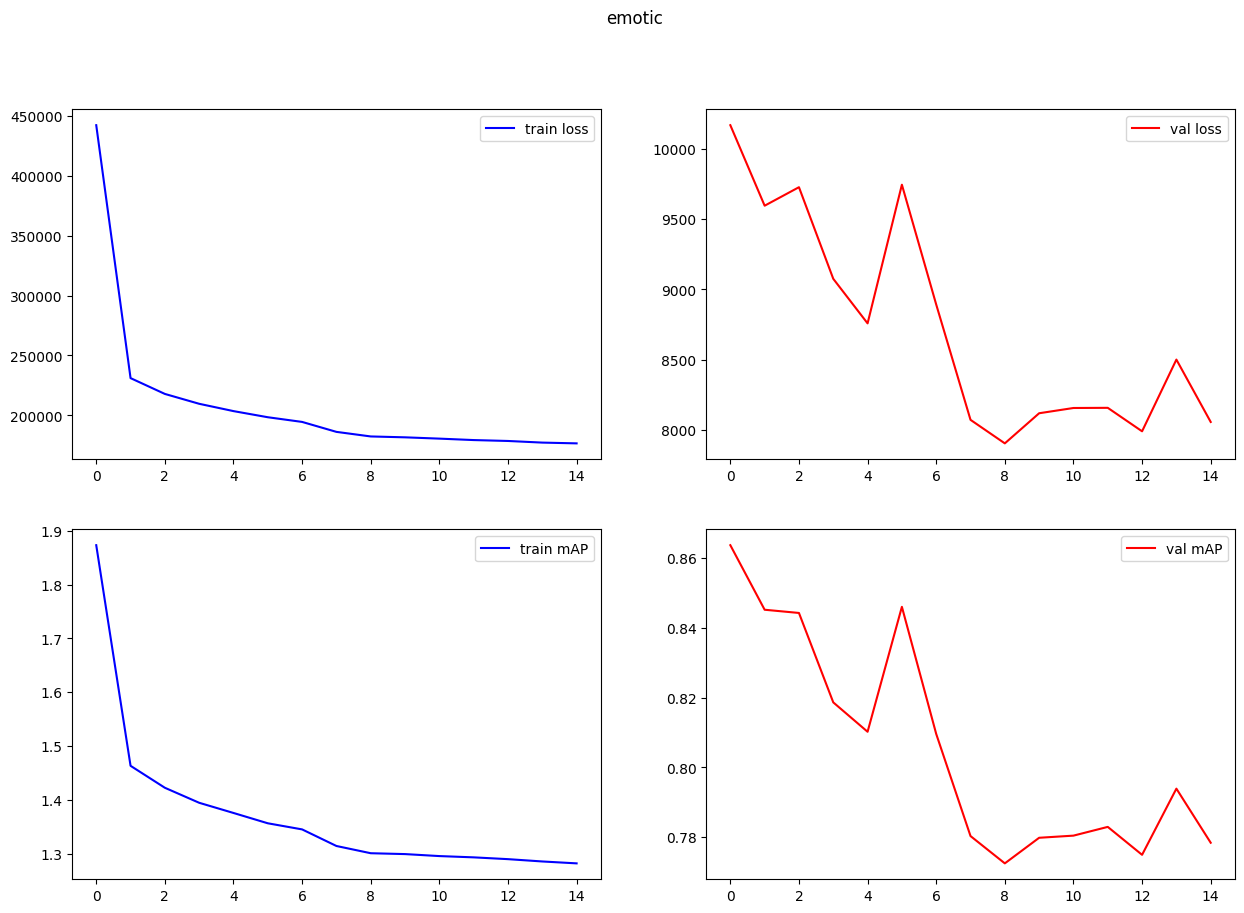

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [ ]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))


model_context.eval()
model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_context, model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.8776545  0.97241557 0.9266031 ] (3,) 0.9255577
0.9255577
testing MAE=0.9256



---
# Train 2


## Resnet50(Emotic) + Resnet50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-22 06:47:40--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  28.5MB/s    in 3.3s    

2023-07-22 06:47:44 (28.5 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = torch.load('/content/drive/MyDrive/VA-prediction/models/body_train_lr001_b24_crossEtropy/model1.pth')


print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# VI. Face Model + EMOTIC Model + Optimizer

## Face Recognition FER2013 Kaggle

In [ ]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [ ]:
model_face = Net(1.0)

In [ ]:
model_face.load_state_dict(torch.load("/content/drive/MyDrive/VA-prediction/models/FER_2013_Kaggle.pth", map_location=lambda storage, loc: storage), strict=False)

<All keys matched successfully>

In [ ]:
print(summary(model_face, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

In [ ]:
model_face_new = nn.Sequential(*(list(model_face.children())[:-1]))

In [ ]:
print(summary(model_face_new, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

## Model + Optimizer

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False
print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters()) + list(model_face.parameters())), lr=0.001, weight_decay=5e-4)

scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)

cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [ ]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        model_face.eval()
        emotic_model.eval()

        indx = 0
        print ('starting testing')
        for images_context, images_body, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            images_face = images_face.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_body, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_body, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    model_context.to(device)
    model_body.to(device)
    model_face.to(device)
    emotic_model.to(device)

    model_context.train()
    model_body.train()
    model_face.train()
    emotic_model.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_body, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      images_face = images_face.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)
      pred_face = model_face(images_face)
      pred_cont = emotic_model(pred_context, pred_body, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    model_context.eval()
    model_body.eval()
    model_face.eval()
    emotic_model.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_body, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        images_face = images_face.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        pred_face = model_face(images_face)
        pred_cont = emotic_model(pred_context, pred_body, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 437915.8478
vad [1.6708306 1.9867669 1.9665225] (3,) 1.8747066
epoch = 0 training MAE = 1.8747
epoch = 0 validation loss = 12371.6288
vad [0.8883614 0.8842537 1.0628774] (3,) 0.9451642
epoch = 0 val MAE= 0.9452
saving model at epoch e = 0
epoch = 1 training loss = 233381.7997
vad [1.1995344 1.6508507 1.5796527] (3,) 1.4766793
epoch = 1 training MAE = 1.4767
epoch = 1 validation loss = 11108.9078
vad [0.8128411  0.9243836  0.95181096] (3,) 0.8963452
epoch = 1 val MAE= 0.8963
saving model at epoch e = 1
epoch = 2 training loss = 218322.0412
vad [1.1346898 1.6249473 1.5196389] (3,) 1.4264253
epoch = 2 training MAE = 1.4264
epoch = 2 validation loss = 11115.7427
vad [0.79863346 0.8248926  1.0671672 ] (3,) 0.8968978
epoch = 2 val MAE= 0.8969
epoch = 3 training loss = 211558.8114
vad [1.1055664 1.6079173 1.4903623] (3,) 1.401282
epoch = 3 training MAE = 1.4013
epoch = 3 validation loss = 9579.3371
vad [0.7996351  0.95536214 0.7887449 ] (3,) 0.84791404
epoch = 3 val 

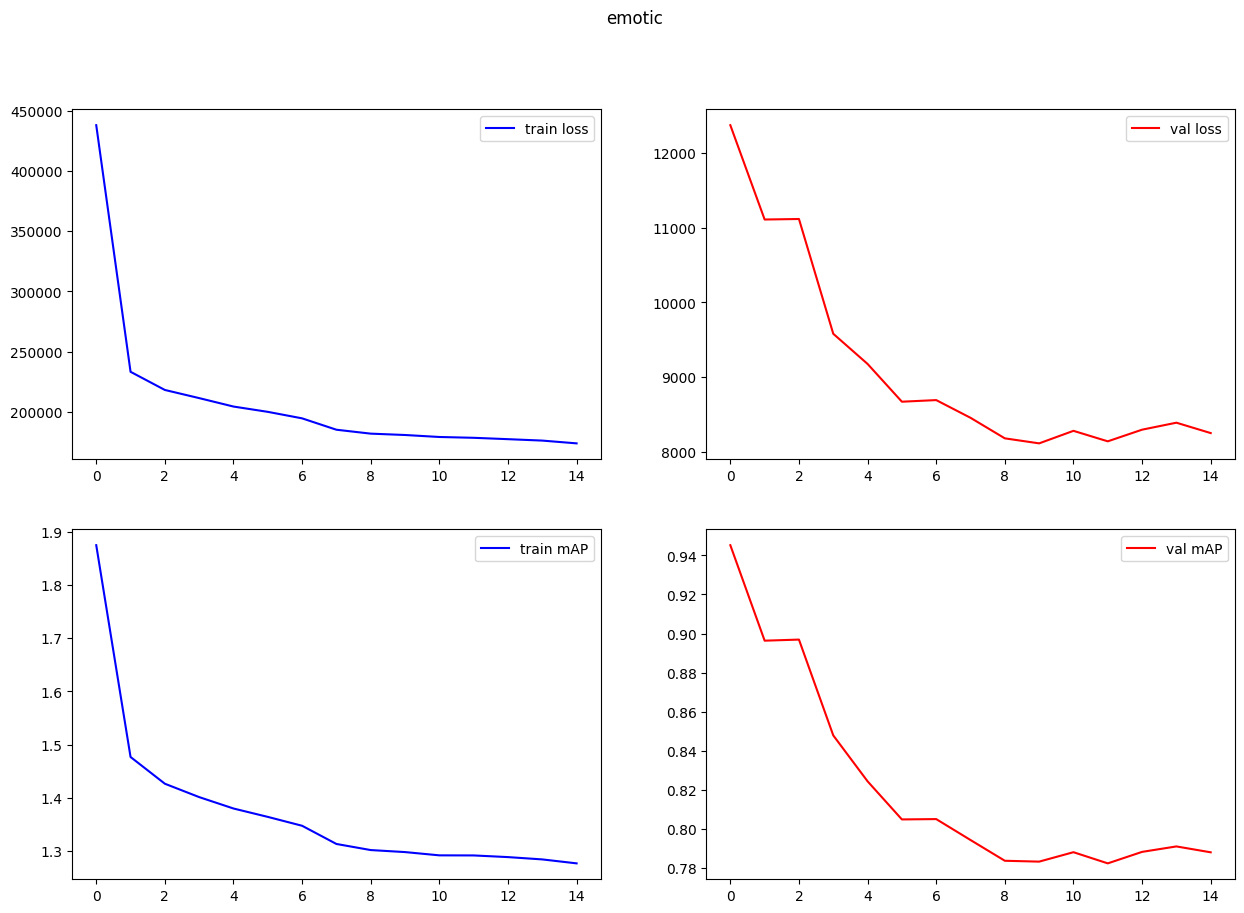

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [ ]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))


model_context.eval()
model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_context, model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.89274615 1.0053269  0.93200916] (3,) 0.94336075
0.94336075
testing MAE=0.9434
